In [1]:
import numpy as np
import pandas as pd
import os
import json
from tqdm import tqdm

papers_name = 'papers-2017-02-21' 
papers_dir = os.path.join('papers', papers_name)
papers_file = papers_name + '.json'
papers_path = os.path.join(papers_dir, papers_file)

def savefile(papers, filename):
    '''
    USAGE: 
    Dump object into JSON file.
    
    ARGUMENTS: 
    papers - object to dump
    filename - location to dump object
    '''
    with open(filename, 'w') as new_f:
        json.dump(papers, new_f)

    print('%d papers saved to "%s."' % (len(papers), filename))

def big2smalls(filepath):
    '''
    USAGE: Split large JSON file of objects into many smaller files
    ARGUMENT: filepath - location of file to split
    '''
    papers = []
    skipped = 0
    suffix = 0
    
    folder = 'smalls'
    dir_and_file = os.path.split(filepath)
    new_dir = os.path.join(dir_and_file[0], folder)
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
    new_file = os.path.join(new_dir, os.path.splitext(dir_and_file[1])[0])
    
    print('Loading file from "%s"...' % filepath)
    with open(filepath, 'r', encoding='utf-8') as f:
        for num, line in tqdm(enumerate(f)):
            try:
                paper = json.loads(line)
                papers.append(paper)
            except:
                print('Error in entry [%d]. Skipping.' % num)
                skipped += 1

            if num and num % 1E5 == 0:
                filename = '%s-%d.json' % (new_file, suffix)
                savefile(papers, filename)
                suffix += 1
                papers = []
        
    filename = '%s-%d.json' % (new_file, suffix)
    savefile(papers, filename) # save what's leftover
        
    print('Finished. "%s" split into %d files.' % (filepath, suffix + 1))

big2smalls(papers_path)

In [2]:
num = 70
dir0 = 'papers' 
dir1 = 'papers-2017-02-21'
dir2 = 'smalls'
fname = '%s-%d.json' % (dir1, num)
filepath = os.path.join(dir0, dir1, dir2, fname)

def load_papers(filepath):
    '''
    USAGE: Load object from JSON file.
    ARGUMENT: filepath - location of JSON file
    RETURNS: papers - object loaded from JSON file
    '''
    print('Loading "%s"...' % fname)
    with open(filepath, 'r', encoding='utf-8') as f:
        papers = json.load(f)
    print('Papers loaded.')
    return papers

papers = load_papers(filepath)

Loading "papers-2017-02-21-70.json"...
Papers loaded.


In [3]:
def json2df(papers):
    '''
    USAGE: Convert JSON object to Pandas DataFrame.
    ARGUMENT: papers - list of dictionaries
    RETURNS: df - DataFrame with keys ["year", "title", "paperAbstract", "id"]
    '''
    df = pd.DataFrame(papers)
    df = df[['year', 'title', 'paperAbstract', 'id']]
    df.dropna(axis=0, how='any', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

df_small = json2df(papers)

In [56]:
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

ps = PorterStemmer()
pool_size = 20000

def abstract2df(df_small, idx):
    '''
    USAGE: Use Porter Stemming to process a paper abstract.
    
    ARGUMENT: 
    df_small - DataFrame with keys ["year", "title", "paperAbstract", "id"]
    idx - index locating paper within DataFrame
    
    RETURNS: stem_df - DataFrame with keys ["stems", "counts", "docs"]
    '''
    abstract = df_small.iloc[idx].paperAbstract
    words = word_tokenize(abstract)
    stems = [ps.stem(w).lower() for w in words]
    counts = Counter(stems)
    docs = list(np.ones(len(counts)).astype(int))
    stem_df = pd.DataFrame({'stems': list(counts.keys()), 'counts': list(counts.values()), 'docs': docs})
    stem_df = stem_df[['stems', 'counts', 'docs']]
    return stem_df

def count_stems(df_small, num):
    '''
    USAGE:
    Count up total number of occurrences of each word stem that appears in a random 
    subset of the papers within the df_small DataFrame, and count up the numer of 
    documents each of those word stems appears in.
    
    ARGUMENTS:
    df_small - DataFrame with keys ["year", "title", "paperAbstract", "id"]
    num - number of papers to search through
    
    RETURNS:
    df - DataFrame with keys ["stems", "counts", "docs"] sorted by "counts"
    indices - list of indices labeling which papers construct our document pool
    '''
    print('Counting word stems in %d abstracts...' % num)
    assert num <= len(df_small)
    indices = np.random.permutation(len(df_small))[:num]
    df = pd.DataFrame()
    for idx in tqdm(indices):
        stem_df = abstract2df(df_small, idx)
        df = pd.concat([df, stem_df])
        if idx and idx % 10 == 0 or idx == len(df_small) - 1:
            df = df.groupby('stems').sum()
            df['stems'] = df.index
            df = df[['stems', 'counts', 'docs']]
    
    df.sort_values('counts', ascending=False, inplace=True)
    print('Stems counted.')
    
    return df, indices

all_stems, indices = count_stems(df_small, pool_size)

Counting word stems in 20000 abstracts...


100%|██████████████████████████████████████████| 20000/20000 [16:40<00:00, 19.99it/s]


Stems counted.


In [58]:
def docs2idf(df, num):
    '''
    USAGE: 
    Get an inverse document frequency (idf) measure for each stem, 
    and add that measure to the word stem DataFrame.
    
    ARGUMENTS:
    df - word stem DataFrame
    num - total number of papers in document pool
    '''
    df['idf'] = np.log(num/df['docs'])
    return df

all_stems = docs2idf(all_stems, pool_size)

In [61]:
def get_common_stems(all_stems, dims):
    '''
    USAGE: 
    Select only the most common stems from all_stems.
    
    ARGUMENTS:
    all_stems - DataFrame with keys ["stems", "counts"]
    dims - number of stems to keep
    
    RETURNS:
    commons_stems - shortened DataFrame with numbered indices
    '''
    assert dims <= len(all_stems)
    common_stems = all_stems.reset_index(drop=True).iloc[:dims]
    del common_stems['counts']
    del common_stems['docs']
    return common_stems

common_stems = get_common_stems(all_stems, 100000)

In [72]:
samples = 5000

def papers2matrix(common_stems, samples, indices):
    '''
    USAGE: ### ADD INFO ABOUT IDF
    Embed a random selection of paper abstracts in a high-dimensional space where each 
    dimension represents the "term frequency-inverse document frequency" (tf-idf) of a 
    given word stem. The tf-idf is a product of the {relative frequency with which a 
    term appears in a single document} and the log of the {total number of papers in
    the document pool divided by the number of documents in which a term appears}. Only 
    the highest-frequency stems (previously determined and stored in the common_stems 
    DataFrame in descending order) found on average in the larger dataset are kept in this 
    analysis to limit the embedding dimensionality.
    
    ARGUMENTS:
    common_stems - DataFrame of most commonly appearing word stems in our dataset 
    samples - number of abstracts to embed
    indices - list of indices labeling which papers from df_small construct our document pool
    
    RETURNS:
    matrix - 2D array of embedded paper-abstract row vectors
    info - list of ['id', 'year', 'title'] lists corresponding to each paper embedded
    '''
    
    assert samples <= len(df_small)
    matrix = np.zeros((samples, len(common_stems)))
    np.random.shuffle(indices)
    index_subset = indices[:samples]
    info = []
    i = 0
    idf = np.array(list(common_stems['idf']))
    
    print('Embedding paper abstracts.')
    
    for idx in tqdm(index_subset):
    
        information = list(df_small.iloc[idx][['id', 'year', 'title']])
        info.append(information)
        
        df = pd.merge(common_stems, abstract2df(df_small, idx), on='stems', how='left').fillna(0)
        vec = np.array(list(df['counts']))
        vec /= np.sum(vec) # components sum to 1
        vec *= idf         # apply inverse document frequency
        matrix[i, :] = vec
        
        i += 1
    
    print('Paper abstracts converted to vectors.')
    
    return matrix, info

matrix, info = papers2matrix(common_stems, samples, indices)

Embedding paper abstracts.


100%|████████████████████████████████████████████| 5000/5000 [11:41<00:00,  6.92it/s]


Paper abstracts converted to vectors.


In [73]:
## Note: dimensionality reduction --> PCA for dense data, TruncatedSVD for sparse data
## (http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from time import time

def reduce_dim(matrix, dims):
    '''
    USAGE: Perform Truncated SVD to reduce dimensionality of embedding space.
    
    ARGUMENTS: 
    matrix - training data (sparse matrix) with shape (n_features, n_samples)
    dims - number of dimensions to project data into
    
    RETURNS:
    X_new - array of reduced dimensionality
    '''
    
    tic =time()
    print('Performing Truncated SVD...')
    svd = TruncatedSVD(n_components = dims, random_state = 1)
    X = svd.fit_transform(matrix) # matrix.shape = (n_samples, n_features)
    toc = time()
    print('Embeddings reduced from %d to %d dimensions through TruncatedSVD. (Time elapsed: %.2f s)' 
          % (matrix.shape[1], dims, (toc-tic)))
    return X

# with X_embedded.shape = (5000, 128), perplexity = 30, elapsed TSNE time ~ 5 minutes.
def TSNE2D(X):
    '''
    USAGE: Perform TSNE to reduce embedding space to 2D
    ARGUMENT: X - high-dimensional training array (n_samples, n_features ~ 100)
    RETURNS: X_embedded - 2D matrix (n_samples, 2)
    '''
    
    tic = time()
    print('Performing TSNE...')
    X_embedded = TSNE(n_components=2, perplexity=30, random_state = 1).fit_transform(X)
    toc = time()
    print('Embeddings reduced to 2 dimensions through TSNE. (Time elapsed: %.2f s)' % (toc-tic))
    return X_embedded

X = reduce_dim(matrix, 128)
X_embedded = TSNE2D(X)

Performing Truncated SVD...
Embeddings reduced from 100000 to 128 dimensions through TruncatedSVD.
Performing TSNE...
Embeddings reduced to 2 dimensions through TSNE. (Time elapsed: 306.72 s)


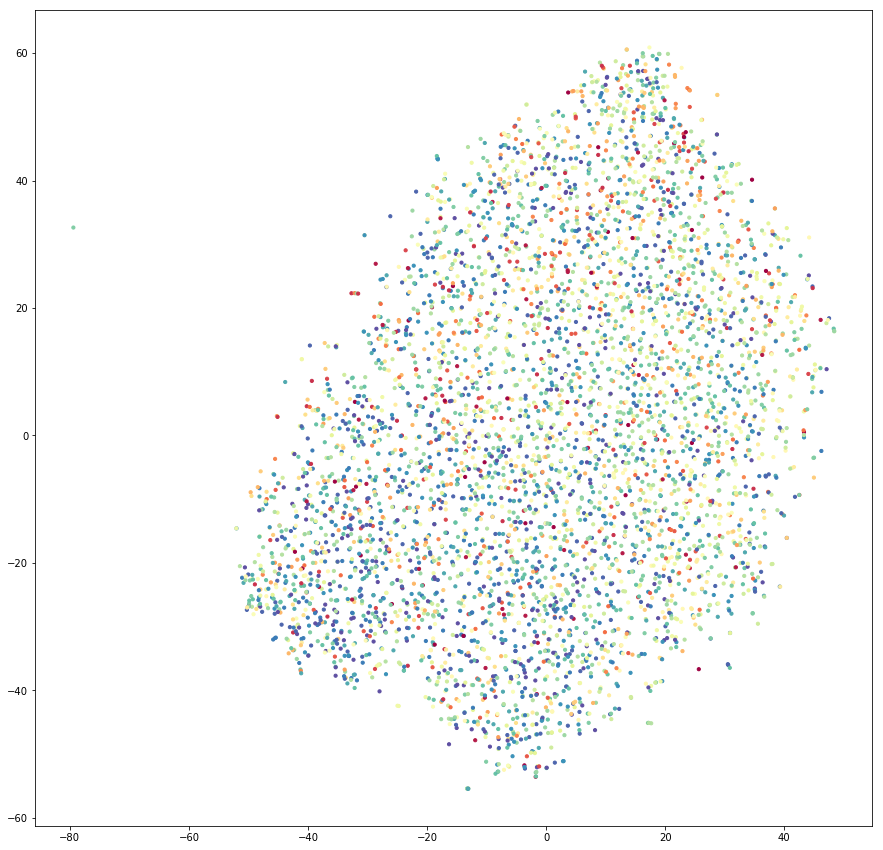

In [74]:
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm

def plot_2D(X, info):
    '''
    USAGE: 
    Create scatter plot of points in array with shape (n_samples, 2)
    
    ARGUMENTS: 
    X - 2D array of shape (n_samples, 2)
    info - list of ['id', 'year', 'title'] lists corresponding to each paper embedded 
    '''
    x = X[:, 0]
    y = X[:, 1]
    
    years = list(np.array(info).T[1].astype(float))
    maxi = max(years)
    mini = min(years)
    
    norm = matplotlib.colors.Normalize(vmin = mini, vmax = maxi, clip = True)
    cmap = cm.Spectral
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    colors = [mapper.to_rgba(x) for x in years]
    
    plt.figure(figsize = (15,15))
    plt.scatter(x,y, s = 10, c = colors)
    plt.show()
    
plot_2D(X_embedded, info)

In [75]:
destination = os.path.join(dir0, dir1, 'processed', os.path.splitext(fname)[0] + '-p_0.json')

def get_filepath(filepath):
    '''
    USAGE: Iterate filepath suffix index up by 1 if filename is already taken.
    ARGUMENT: filepath - string with format (root + num + .extension)
    RETURNS: returns filepath if it doesn't exist, otherwise, executes function again.
    '''
    if not os.path.exists(filepath):
        return filepath 
    else:
        root = filepath.split('_')[0] + '_'
        num = int(filepath.split('_')[1].split('.')[0])
        ext = '.' + filepath.split('.')[1]
        new_path = '%s%d%s' % (root, num + 1, ext)
        return get_filepath(new_path)
    

def export_data(X, info, destination):
    '''
    USAGE: 
    Export embeddings and their info to JSON file.
    
    ARGUMENTS:
    X - list of [x, y] lists of coordinates
    info - list of ['id', 'year', 'title'] lists corresponding to each paper embedded
    '''
    destination = get_filepath(destination)
    data = {'X': X.tolist(), 'info': info}
    with open(destination, 'w') as fp:
        json.dump(data, fp)
    print('Processed data exported to "%s".' % destination)
    
export_data(X_embedded, info, destination)

Processed data exported to "papers\papers-2017-02-21\processed\papers-2017-02-21-70-p_12.json".
